<a href="https://www.kaggle.com/code/mohammedmohsen0404/proj33-nlp-movies-rs-using-collaborative-filtering?scriptVersionId=197250862" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

---
**<center><h1>Movies RS using Collaborative Filtering</h1></center>**
<center><h3>Learning ML, DL through 100 Practical Projects</h3></center>

---


This project aims to build a movie recommender system using collaborative filtering on the MovieLens dataset, which contains 105,339 ratings for 10,329 movies from 668 users. Collaborative filtering, a popular recommendation algorithm, works by finding patterns in user interactions with movies particularly by identifying users with similar preferences or movies that are frequently rated similarly by different users. The goal is to suggest new movies to users based on these shared patterns, helping users discover movies they are likely to enjoy. The system will focus on user-item interactions, leveraging techniques like matrix factorization or user-based collaborative filtering

# **Import Libraries and Data**
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras import layers, models, regularizers, metrics, optimizers
from keras.utils import plot_model

In [2]:
!kaggle datasets download -d ayushimishra2809/movielens-dataset
!unzip movielens-dataset.zip

Dataset URL: https://www.kaggle.com/datasets/ayushimishra2809/movielens-dataset
License(s): unknown
100%|████████████████████████████████████████| 875k/875k [00:00<00:00, 1.77MB/s]
100%|████████████████████████████████████████| 875k/875k [00:00<00:00, 1.77MB/s]
Archive:  movielens-dataset.zip
  inflating: movies.csv              
  inflating: ratings.csv             


In [3]:
movies = pd.read_csv('movies.csv').copy()
ratings = pd.read_csv('ratings.csv').copy()

# **Take a look at the data**
---

In [4]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


In [6]:
pd.crosstab(ratings.userId, ratings.movieId).head()

movieId,1,2,3,4,5,6,7,8,9,10,...,144482,144656,144976,146344,146656,146684,146878,148238,148626,149532
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# **Data Preprocessing**
--------

In [7]:
k = 15
g = ratings.groupby('userId')['rating'].count()
top_users = g.sort_values(ascending=False)[:k]

g = ratings.groupby('movieId')['rating'].count()
top_movies = g.sort_values(ascending=False)[:k]

top_r = ratings.join(top_users, rsuffix='_r', how='inner', on='userId')
top_r = top_r.join(top_movies, rsuffix='_r', how='inner', on='movieId')

pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)

/tmp/ipykernel_17/4260461852.py:11: FutureWarning: The provided callable <function sum at 0x7e1d43af8ca0> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  pd.crosstab(top_r.userId, top_r.movieId, top_r.rating, aggfunc=np.sum)


movieId,1,50,110,260,296,318,356,457,480,527,589,593,1196,1198,2571
userId,,,,,,,,,,,,,,,
62,2.0,3.0,3.0,2.5,5.0,4.5,4.0,1.0,3.0,5.0,4.0,4.5,3.0,1.0,1.5
63,NaN,4.5,3.0,4.5,3.5,4.0,4.5,3.0,3.0,NaN,3.5,3.5,5.0,4.0,5.0
128,3.0,5.0,4.5,3.5,5.0,5.0,4.5,4.0,3.5,3.5,3.5,4.0,4.0,4.0,4.0
224,4.5,5.0,4.0,3.5,4.5,5.0,5.0,4.0,4.5,4.0,4.5,4.0,4.5,4.0,4.5
232,3.5,NaN,4.0,4.0,4.5,4.0,4.0,4.5,3.5,NaN,4.5,4.0,4.0,5.0,4.5
310,3.0,4.0,4.0,3.0,4.0,4.5,3.5,4.0,3.0,4.0,4.5,3.5,3.5,3.0,4.0
413,4.0,2.5,NaN,4.0,4.5,5.0,4.0,NaN,5.0,4.0,4.0,3.5,4.0,4.0,5.0
451,3.5,4.5,4.0,4.5,4.5,4.0,NaN,4.0,4.0,NaN,4.0,5.0,4.0,4.5,3.5
458,3.5,5.0,5.0,4.5,5.0,4.0,4.0,4.0,2.0,5.0,5.0,5.0,4.5,5.0,5.0


**Data Encoding**

In [8]:
user_enc = LabelEncoder()
ratings['user'] = user_enc.fit_transform(ratings.userId.values)
n_users = ratings['user'].nunique()

item_enc = LabelEncoder()
ratings['movie'] = user_enc.fit_transform(ratings.movieId.values)
n_movies = ratings['movie'].nunique()

ratings['rating'] = ratings['rating'].values.astype(np.float32)
min_rating = min(ratings['rating'])
max_rating = max(ratings['rating'])

n_users, n_movies, min_rating, max_rating

(668, 10325, 0.5, 5.0)

**Data Splitting**

In [9]:
X = ratings[['user', 'movie']].values
y = ratings['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(94805, 2) (94805,)
(10534, 2) (10534,)


# **Modelling**
---



In [10]:
# Number of latent factors
emb_sz = 50

# User embeddings
user = layers.Input(shape=(1,))
user_emb = layers.Embedding(n_users, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_emb = layers.Reshape((emb_sz,))(user_emb)

# User bias
user_bias = layers.Embedding(n_users, 1, embeddings_regularizer=regularizers.l2(1e-6))(user)
user_bias = layers.Reshape((1,))(user_bias)

# Movie embeddings
movie = layers.Input(shape=(1,))
movie_emb = layers.Embedding(n_movies, emb_sz, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_emb = layers.Reshape((emb_sz,))(movie_emb)

# Movie bias
movie_bias = layers.Embedding(n_movies, 1, embeddings_regularizer=regularizers.l2(1e-6))(movie)
movie_bias = layers.Reshape((1,))(movie_bias)

# Dot product
rating = layers.Concatenate()([user_emb, movie_emb])

# Add biases
rating = layers.Add()([rating, user_bias, movie_bias])
rating = layers.Dense(10, activation='relu')(rating)
rating = layers.Dropout(0.5)(rating)
rating = layers.Dense(1, activation='sigmoid')(rating)
rating = layers.Lambda(lambda x:x*(max_rating - min_rating) + min_rating)(rating)

# Model
model = models.Model([user, movie], rating)

In [11]:
model.compile(loss='mse', metrics=['RootMeanSquaredError'],
              optimizer=optimizers.Adam(learning_rate=0.001))

print(model.summary())

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 1, 50)     │     33,400 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_2         │ (None, 1, 50)     │    516,250 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 50)        │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, 50)        │          0 │ embedding_2[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 1, 1)      │        668 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_3         │ (None, 1, 1)      │     10,325 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 100)       │          0 │ reshape[0][0],    │
│ (Concatenate)       │                   │            │ reshape_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, 1)         │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 1)         │          0 │ embedding_3[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 100)       │          0 │ concatenate[0][0… │
│                     │                   │            │ reshape_1[0][0],  │
│                     │                   │            │ reshape_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │      1,010 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         11 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 1)         │          0 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 561,664 (2.14 MB)

 Trainable params: 561,664 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

None


In [12]:
history = model.fit(x=[X_train[:,0], X_train[:,1]], y=y_train,
          batch_size=64, epochs=5, verbose=1,
          validation_data=([X_test[:,0], X_test[:,1]], y_test))

Epoch 1/5
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 11s 6ms/step - RootMeanSquaredError: 1.0441 - loss: 1.0964 - val_RootMeanSquaredError: 0.8604 - val_loss: 0.7409
Epoch 2/5
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - RootMeanSquaredError: 0.8665 - loss: 0.7516 - val_RootMeanSquaredError: 0.8509 - val_loss: 0.7251
Epoch 3/5
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - RootMeanSquaredError: 0.8426 - loss: 0.7112 - val_RootMeanSquaredError: 0.8549 - val_loss: 0.7323
Epoch 4/5
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - RootMeanSquaredError: 0.8330 - loss: 0.6955 - val_RootMeanSquaredError: 0.8549 - val_loss: 0.7328
Epoch 5/5
1482/1482 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - RootMeanSquaredError: 0.8266 - loss: 0.6853 - val_RootMeanSquaredError: 0.8570 - val_loss: 0.7368


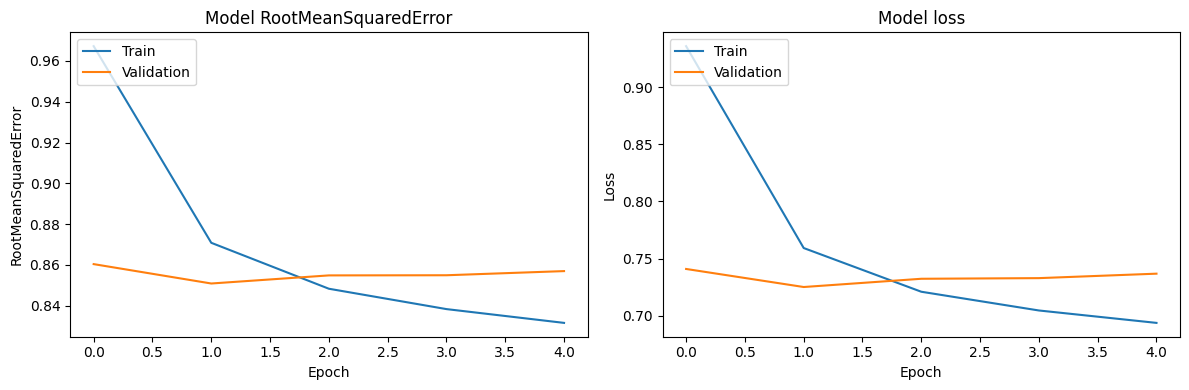

In [13]:
# Plot training & validation RootMeanSquaredError values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['RootMeanSquaredError'])
plt.plot(history.history['val_RootMeanSquaredError'])
plt.title('Model RootMeanSquaredError')
plt.ylabel('RootMeanSquaredError')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

# **Recommendation System**
-------

In [14]:
def predict_ratings(model, user_ids, movie_ids):
    user_ids = np.array(user_ids)
    movie_ids = np.array(movie_ids)
    predictions = model.predict([user_ids, movie_ids])
    return predictions.flatten()


user_ids = [1, 5, 10]
movie_ids = [100, 200, 300]

predicted_ratings = predict_ratings(model, user_ids, movie_ids)
print(predicted_ratings)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
[3.600953  4.247351  3.2495146]
